# Модель подавления поверхностных волн

## Содержание
* [Постановка задачи](#Постановка-задачи)
* [Датасет](#Датасет)
* [Архитектура](#Архитектура)
* [Обучение](#Обучение)
* [Инференс](#Инференс)
* [Оценка модели](#Оценка-модели)
* [Критика](#Критика)

## Постановка задачи

Подавить шумы, связанные с поверхностными волнами, на полевых сейсмограммах.

## Датасет

Исходная сейсмограмма (176К трасс) и сейсмограмма после первой итерации подавления шума.

Загрузка данных:

In [49]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import segyio

sys.path.append('..')

from batchflow import Dataset, DatasetIndex, Pipeline, B, V, best_practice
from batchflow.models.tf import UNet

from geolog import SeismicBatch

%env CUDA_VISIBLE_DEVICES=1

max_length = 50000

with segyio.open('../../noise_data/D01_Raw_shots.sgy', strict=False) as file:
    raw_data = file.trace.raw[:max_length]

with segyio.open('../../noise_data/D02_LIFT_1.sgy', strict=False) as file:
    pro_data = file.trace.raw[:max_length]

df = pd.DataFrame({'traces': np.array([x.reshape((-1, 1)) for x in raw_data] + [None])[:-1],
                   'target': np.array([x.reshape((-1, 1)) for x in pro_data] + [None])[:-1]})

env: CUDA_VISIBLE_DEVICES=1


Создание обучающией и тестовой частм датасета

In [4]:
index = DatasetIndex(np.arange(len(raw_data)))
dset = Dataset(index, SeismicBatch)
dset.split(0.5)

## Архитектура

Используется модель типа U-net глубиной 4. Задание конфигурации модели:

In [34]:
model_config = {
    'initial_block/inputs': 'x',
    'inputs': dict(x={'shape': (3001, 1)}, 
                   y={'name':'targets', 'shape': (3001, 1)}),
    'body/filters': [12, 24, 48, 96],
    'body/encoder': dict(layout='caca', kernel_size=3),
    'body/decoder': dict(layout='caca', kernel_size=3),
    'body/upsample': dict(layout='ta', kernel_size=2, strides=2),
    'loss':'mse',
    'optimizer': 'Adam'
}

## Обучение

Пайплайн обучения модели

In [35]:
def make_data(batch, **kwagrs):
    return {"feed_dict": {'x': np.array(list(batch.traces)),
                          'y': np.array(list(batch.target))}}

train_pipeline = (Pipeline()
                  .load(df, force=True)
                  .init_variable('loss', init_on_each_run=list)
                  .init_model('dynamic', UNet, 'unet', model_config)
                  .train_model('unet', make_data=make_data,
                               fetches='loss', save_to=V('loss'), mode='a')
                 )

Запуск обучения

In [50]:
batch_size = 30

(train_pipeline << dset.train).run(batch_size, n_epochs=1, drop_last=True, shuffle=True, bar=True)

100%|██████████| 833/833 [00:15<00:00, 54.42it/s]


График функции потерь в зависимости от числа итераций

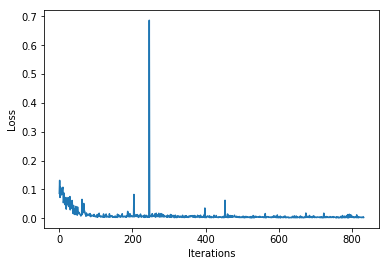

In [51]:
loss = train_pipeline.get_variable("loss")
plt.plot(loss)
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.show()

## Инференс

Пайплайн инференса

In [39]:
predict_pipeline = (Pipeline()
                    .load(df, force=True)
                    .import_model('unet', train_pipeline)
                    .init_variable('predictions', init_on_each_run=list())
                    .predict_model('unet', fetches='predictions', make_data=make_data,
                                   save_to=V('predictions'), mode="a"))

In [40]:
predict_pipeline = predict_pipeline << dset.test

Запуск процедуры инференса

In [41]:
predict_pipeline.run(batch_size, n_epochs=1, drop_last=False, shuffle=False, bar=False)

Сборка трасс

In [42]:
predicts = np.vstack(predict_pipeline.get_variable("predictions"))

Результат подавлениия поверхностных волн

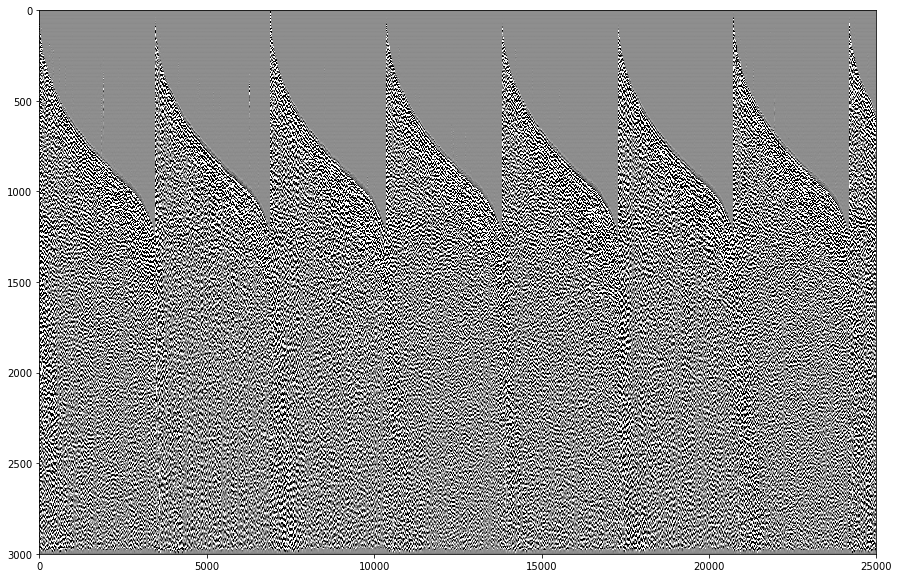

In [52]:
cv = 0.1

plt.figure(figsize=(15, 10))
plt.imshow(np.squeeze(predicts).T, vmin=-cv, vmax=cv, cmap='gray')
plt.axes().set_aspect('auto')
plt.show()

## Оценка модели

Загрузка данных для сравнения

In [ ]:
batch = dset.test.next_batch(len(dset_test)).load(df, force=True)

Исходная сейсмограмма

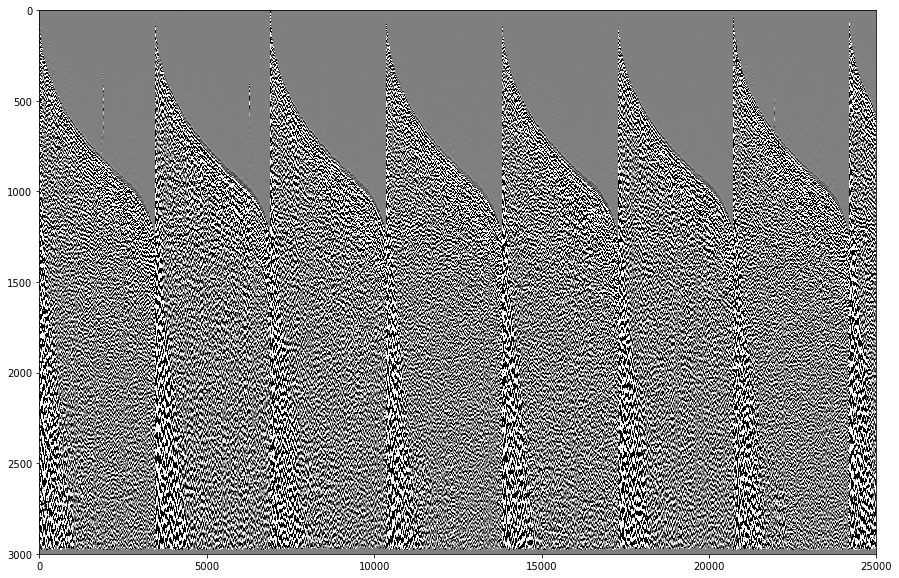

In [19]:
cv = 0.1

plt.figure(figsize=(15, 10))
plt.imshow(np.hstack(batch.traces), vmin=-cv, vmax=cv, cmap='gray')
plt.axes().set_aspect('auto')
plt.show()

Результат ручной обработки поверхностных волн

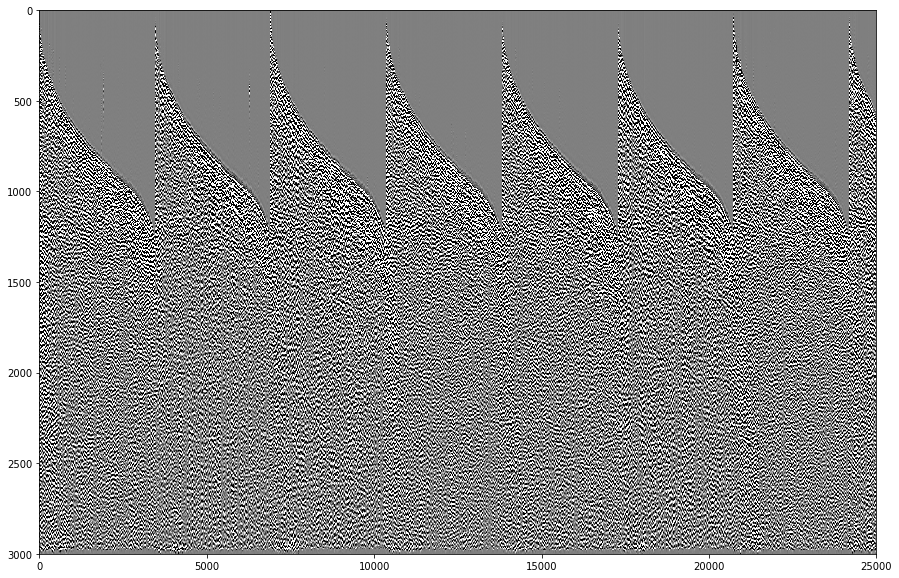

In [95]:
cv = 0.1

plt.figure(figsize=(15, 10))
plt.imshow(np.hstack(batch.target), vmin=-cv, vmax=cv, cmap='gray')
plt.axes().set_aspect('auto')
plt.show()

## Критика

На картинке, полученной в результате работы модели заметны некоторые артефакты подавления поверхностных волн. Их можно пробовать устранять, увеличивая глубину и число фильтров в сети. 